# __Deep Learning Final Project__

## __Project Topic__
This project is meant to serve as a sort of feasibility study for a simple approach to predicting stock market close prices through the use of  Recurrent Neural Networks, specifically for Google's Stock (ticker GOOG) 1-day data. 

The prediction performed on this time-series data will be done via a sliding window approach, utilizing two different LSTM RNN's. One of these will employ a low-parameter architecture, and the other will employ a higher-parameter architecture. The predictions performed will be for the following day's "price change", that is the difference between tomorrow's close and today's. The models will be trained using the first 80% of the data, and metrics such as Root Mean Squared Error, Mean Absolute Error will be evaluated for the actual values, while Accuracy will be evaluated for the model's predictions of the price change's "direction" (up or down). This will be compared to "Naive Forecasting", where the prediction is simply the previous entry in the sequence.

The problem itself is to predict how much tomorrow's closing price will differ from today, given the simple financial data available for the stock, which includes the Date, Open, Low, High, Close, Adj. Close, Dividend, Volume, and Shares Outstanding, for roughly five years worth of data, from 2017-08-21, to 2022-08-19. The stock market is notoriously difficult to predict, so this should prove an ample learning opportunity.

## __Purpose__

My goal with this project is twofold:

- To identify potentially promising architectures for stock value prediction.

- To identify which "window-size" of data turns out to be most relevant to this single-day data (model will look at previous week, month, 90-day)

Although it certainly would be nice if one of these models was just able to outperform the naive baseline, it's not likely. I am hoping to use what I learn in this project as a foundation for future projects.

In [873]:
#import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,BatchNormalization
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix
import warnings

In [2]:
# ignore future warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

## __Data__

Below I import the full dataset, and print some of its size parameters.

In [3]:
data_file = "A:/DL_Final_Project/dataset/us-shareprices-daily.csv"
fulldf = pd.read_csv(data_file, delimiter=";")
print("number of stocks in full dataset: {}".format(len(fulldf["Ticker"].unique())))
print("shape of full dataset: {}".format(np.shape(fulldf)))

number of stocks in full dataset: 4722
shape of full dataset: (4848187, 11)



The dataset used for this project is SimFin.com's USA Market Share Prices, five years of which is available for free to download from their website if you make an account. It contains information for 4,722 different stocks, with 1,259 trading day entries for each (5 years worth of data since market is only open 5/7 days). The actual value I'm trying to predict is derived from the "Close" value within the dataset.

In [4]:
print(fulldf.keys())

Index(['Ticker', 'SimFinId', 'Date', 'Open', 'Low', 'High', 'Close',
       'Adj. Close', 'Dividend', 'Volume', 'Shares Outstanding'],
      dtype='object')


Here I pull only the stock I'm interested in training to, which is Google's, and print it's shape

In [1037]:
#pull GOOG ticker
df = fulldf[fulldf["Ticker"] == "GOOG"]
#print shape
print("shape of GOOG stock data:",np.shape(df))

shape of GOOG stock data: (1259, 11)


## __Exploratory Data Analysis and Feature Engineering__

The exploratory Data Analysis for this project revolves around creating as many "traditional" stock trading features as possible, and then pruning those where collinearity is too prevalent between features. Collinearity might not be immediately an issue


So to start, let's go over the metrics I have to start with:

In [1038]:
df.head()

,Ticker,SimFinId,Date,Open,Low,High,Close,Adj. Close,Dividend,Volume,Shares Outstanding
0,GOOG,18,2017-08-21,45.50,45.17,45.65,45.33,45.33,NaN,18658060,1.385759e+10
1,GOOG,18,2017-08-22,45.64,45.57,46.29,46.23,46.23,NaN,22911420,1.385759e+10
2,GOOG,18,2017-08-23,46.10,45.97,46.50,46.35,46.35,NaN,21556180,1.385759e+10
3,GOOG,18,2017-08-24,46.43,45.77,46.54,46.06,46.06,NaN,24377500,1.385759e+10
4,GOOG,18,2017-08-25,46.17,45.77,46.28,45.79,45.79,NaN,20813860,1.385759e+10


Here's some explanation regarding the metrics we currently have access to (those excluded are deemed irrelevant)

-Open: Price at beginning of day

-Low: Lowest price of the day

-High: Highest price of the day

-Close: Price at end of the day

-Adj. Close: Adjusted metric to better reflect value of stock's closing price

-Volume: Number of shares or contracts traded on that given day

-Shares Outstanding: Total number of shares of a company's stock in the hands of investors

### Current Data

Before we do any feature engineering, let's get a good look at what we're dealing with in terms of collinearity between our starting features. Collinearity in this kind of model can make our model overfit to certain features within the data, which is something I want to avoid. Since neural networks excel in modelling non-linear functions, I would like the model to have a reasonable mix of linear and non-linear features. 

Below is a plot of the Close price, the thing we are ultimately trying to predict via the price change.

<Axes: xlabel='Date'>

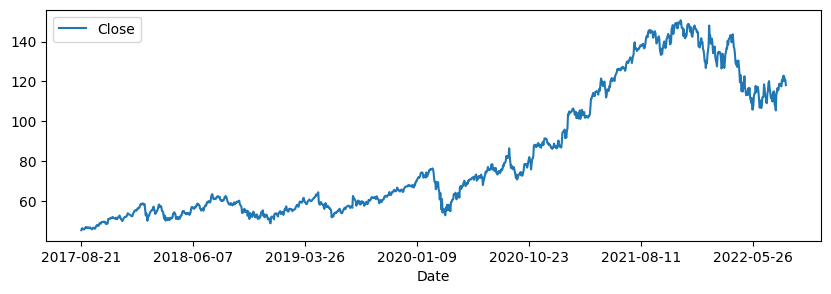

In [1039]:
df.plot(x = "Date", y = "Close", figsize= (10,3))

Below is a scatter matrix of the currently relevant features:

c:\Users\Angel\anaconda3\envs\tf210\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


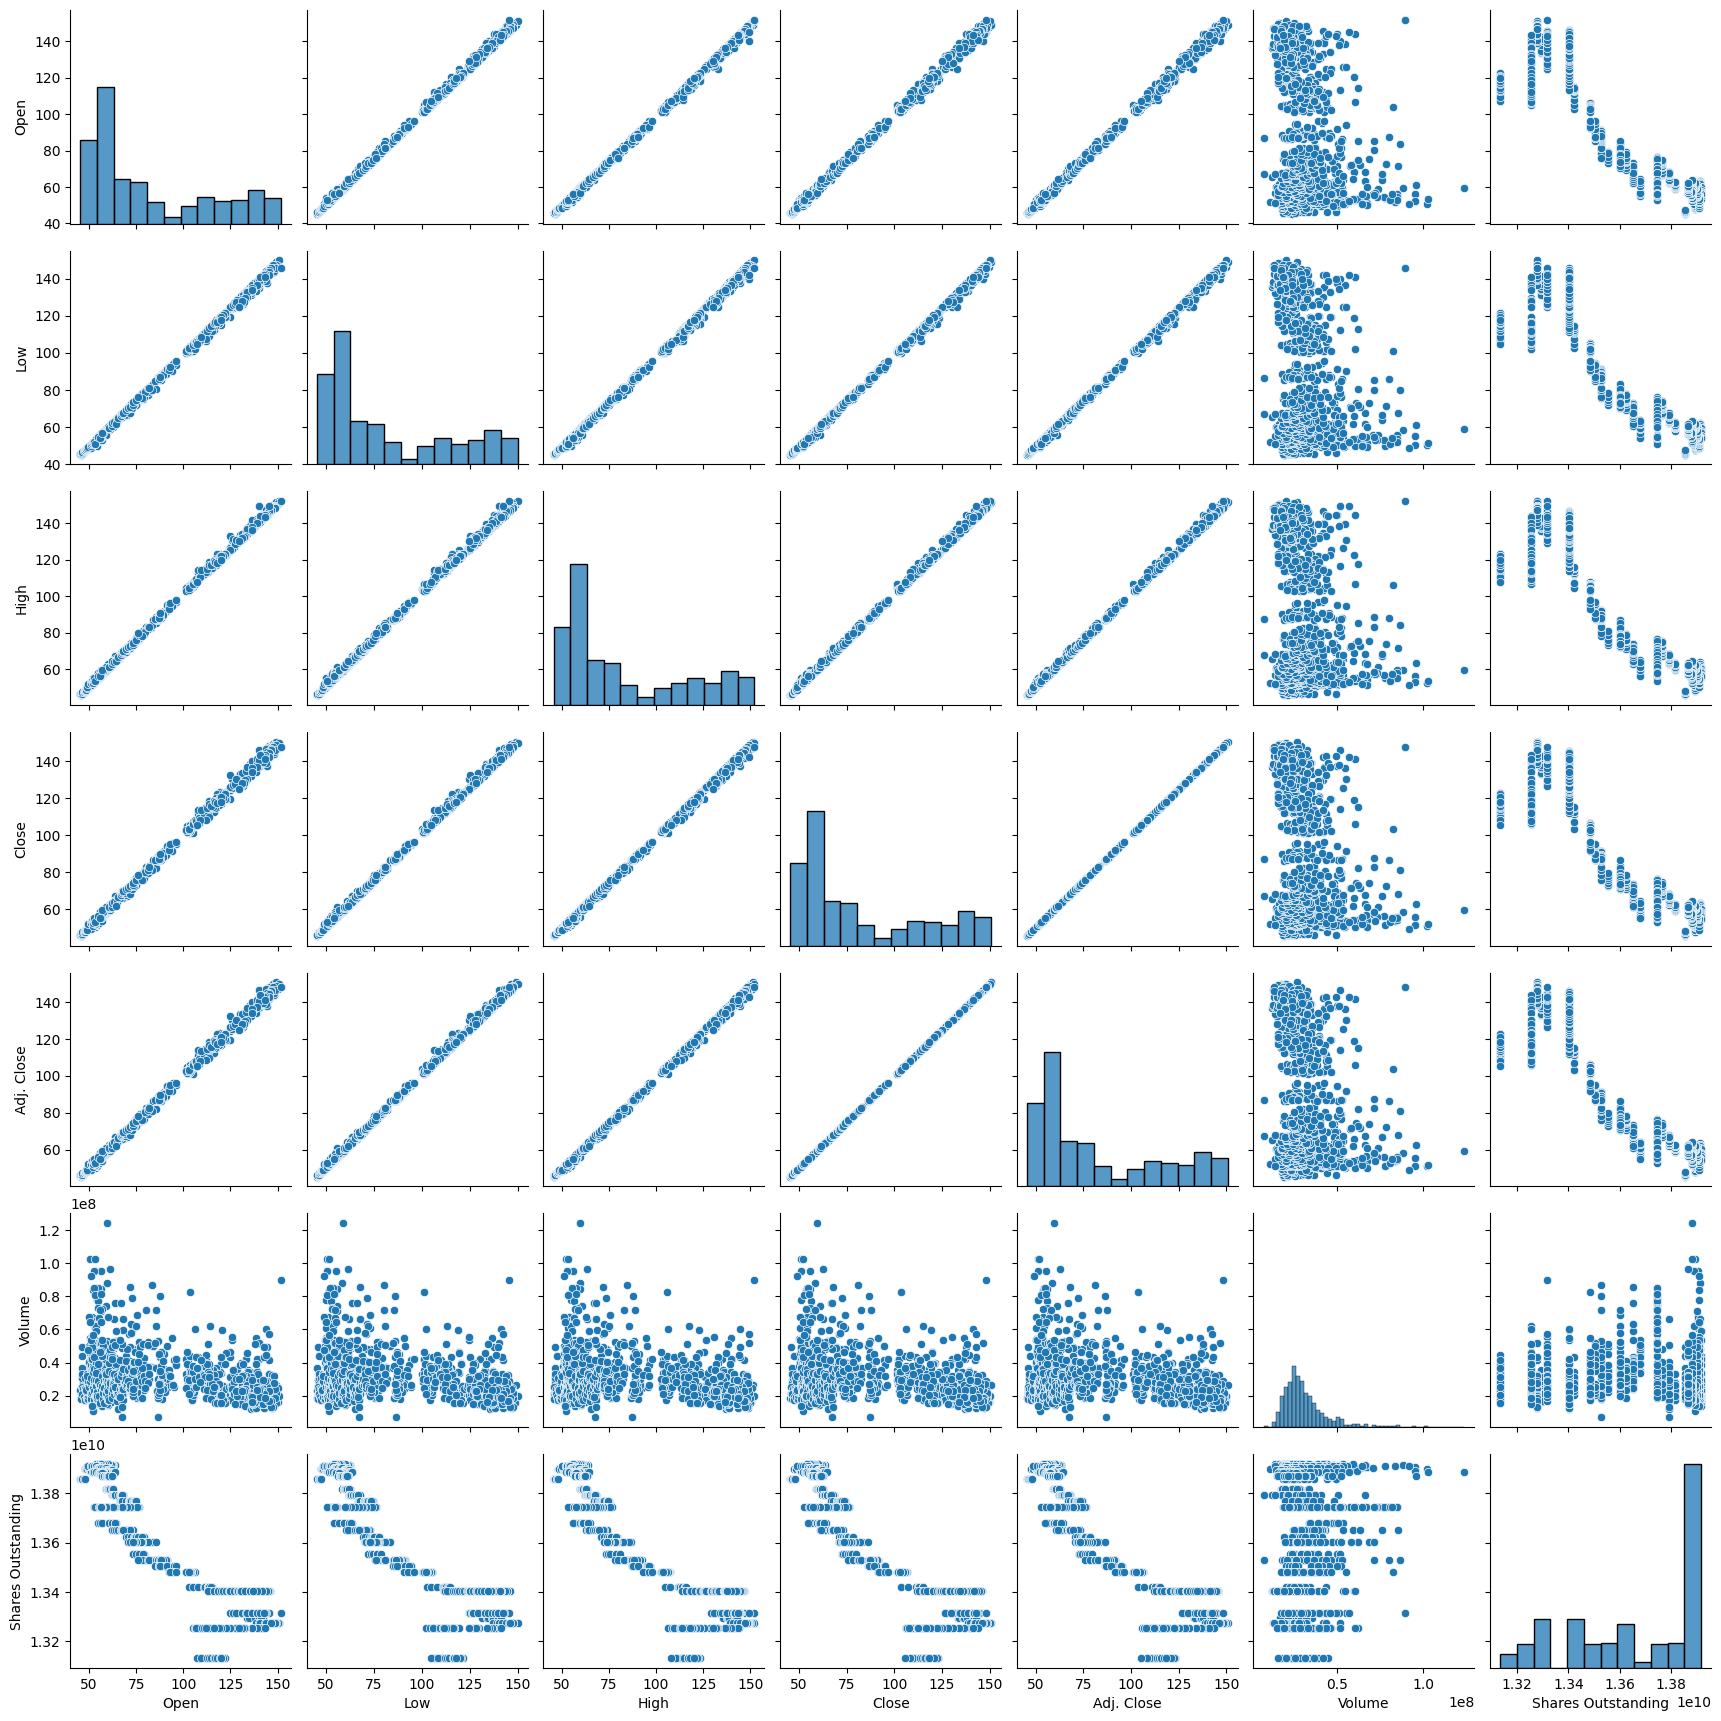

In [1040]:
relevant = features = ["Open","Low","High","Close","Adj. Close",'Volume', 'Shares Outstanding']
df_plot = df[relevant]
sns.pairplot(df_plot)
plt.show()

Below is a the corresponding correlation matrix and heatmap of the currently relevant features:

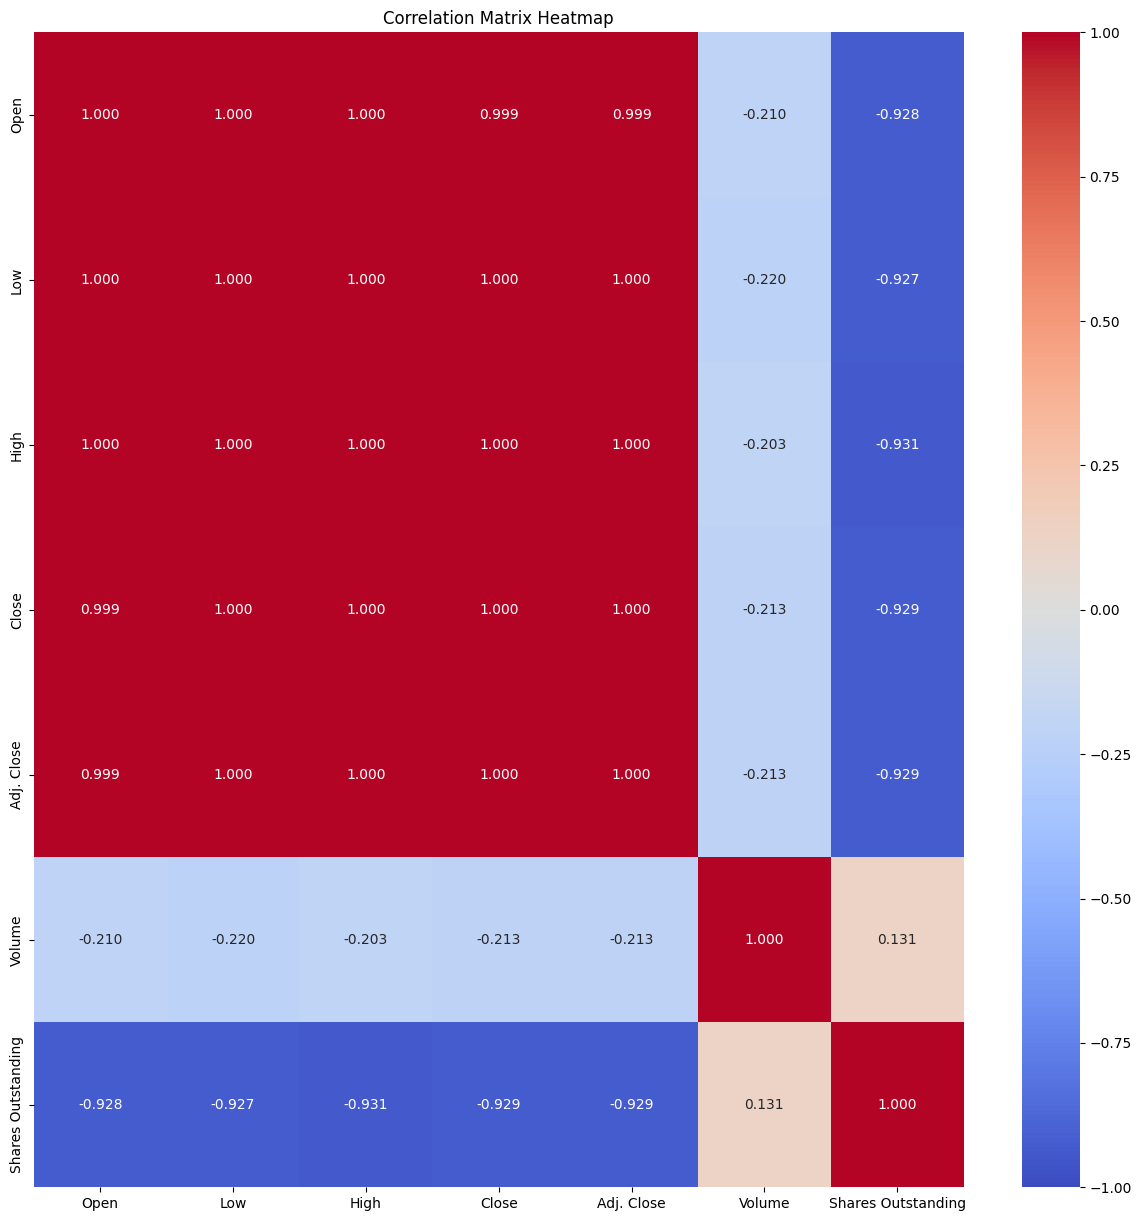

In [1041]:
correlation_matrix = df_plot.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".3f")
plt.title("Correlation Matrix Heatmap")
plt.show()

Many of these features would of course be near-perfectly correlated, given that they are values specific to a particular day, and it's a relatively stable stock. The stock ranges from 40 to 140 over a five year period, so it becomes only natural that the relatively small daily variations wouldn't mean much in the grand scheme of things. With that now obvious, we should derive some metrics so that things like High,Low,Open, and Adj. Close can be removed entirely. Thankfully, there are many of those.

## Feature Engineering

I won't go too into depth on each of these features, simply because there are so many. They were primarily chosen for their prominence within stock trading, and for them not being clearly collinear with the Close price (things such as moving averages, channels, bands, etc.).

#### _MACD_

MACD stands for "Moving Average Convergence Divergence", which is the difference between a short-term exponential moving average, and a longer term exponential moving average. The MACD signal line is based on a shorter window than the two, and it's relationship with MACD line is often used as a trading signal, meaning various thing. This relationship is then turned into it's own, all-in-one indicator, the MACD histogram. The window sizes themselves have been chosen based solely on the historical precedent of these values.

In [1042]:
short_window = 12
long_window = 26 
signal_window = 9
#exponentially weighted moving, followed by averaging to create exponentially weighted averages.
df['EMA_short'] = df['Close'].ewm(span=short_window,adjust=False).mean()
df['EMA_long'] = df["Close"].ewm(span=long_window, adjust=False).mean()
# MACD Base line
df['MACD'] = df['EMA_short'] - df['EMA_long']
df['MACD_signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
#MACD histogram
df['MACD_hist'] = df["MACD_signal"] - df["MACD"]

<Axes: xlabel='Date'>

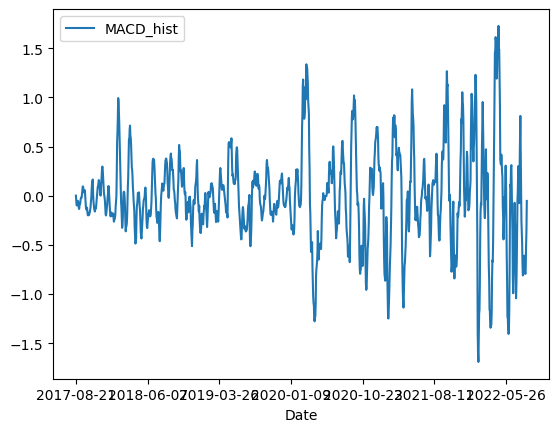

In [1043]:
df.plot(x = "Date", y = "MACD_hist")

#### _Standard Deviation_

This is just the rolling standard deviation of the data. I chose a window size of 10 (two weeks), so that the value could be fairly responsive to sharp changes, but not change too crazily.

In [1044]:
window_size = 10
df["STD"] = df['Close'].rolling(window_size).std()

<Axes: xlabel='Date'>

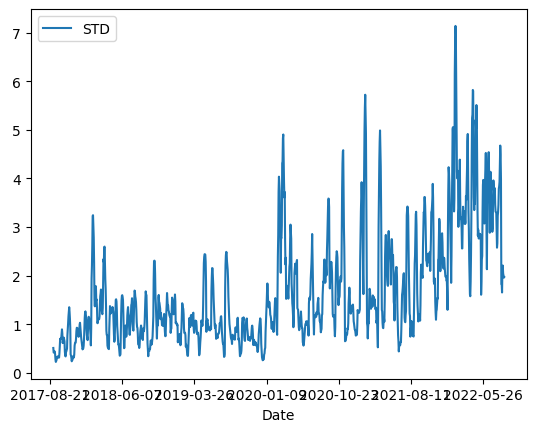

In [1045]:
df.plot(x = "Date", y ="STD")

#### _Relative Strength Index_, _Price change_

The Relative Strength Index is meant to indicate the "momentum" of a stock, from a scale of 0-100. High RSI values may indicate that it is overbought and will experience a downturn, while lower values mean the opposite. Once again the window size of 14 has been chosen for it's historical precedent.

Price change, which is the value I am trying to predict, is simply just the difference between today's closing price and tomorrow's

In [1046]:
df["Price Change"] = df['Close'].diff()

#masks for those causing a gain
mask = df["Price Change"] > 0
# pulls only the positive changes
gain = df["Price Change"].copy()
gain.loc[~mask] = 0
# pulls only the negative changes, calculates magnitudes
loss = (df["Price Change"].copy()).abs()
loss.loc[mask] = 0
# gets rolling average
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
# ratio
rs = avg_gain/avg_loss
# create index
df['RSI'] = 100 - (100 / (1 + rs))


<Axes: xlabel='Date'>

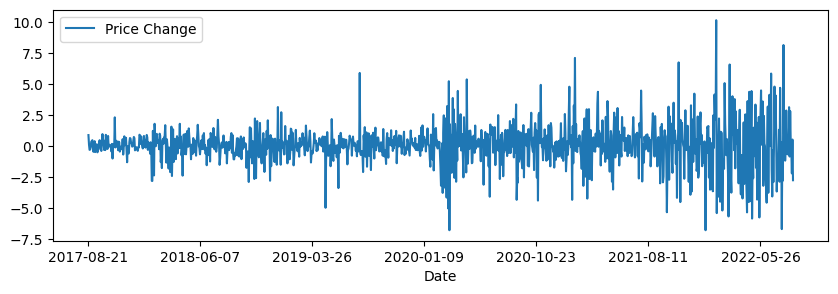

In [1047]:
df.plot(x = "Date",y = "Price Change",figsize = (10,3))

<Axes: xlabel='Date'>

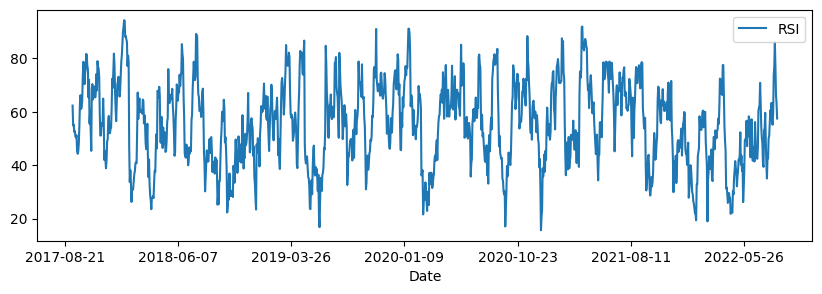

In [1048]:
df.plot(x = "Date",y = "RSI",figsize = (10,3))

#### _Stochastic Oscillator Divergence_ 

The stochastic oscillator is another "momentum" indicator, this time comparing the Close value to the highest highs and lowest lows within a time period (the defined range). The "Fast Stochastic" %K represents the position of the close, relative to the range, and the "slow stochastic" %D is a smoothed, rolling average of %K. %K "crossing over" %D in different contexts can be a predictor of certain price movements. This relationship has been encoded into a single Stochastic Oscillator Divergence, the difference between the two.

In [1049]:
min_range = df['Low'].rolling(window=14).min()
max_range = df['High'].rolling(window=14).max()

df['%K'] = ((df['Close']-min_range)/(max_range - min_range)) * 100
df['%D'] = df['%K'].rolling(window=3).mean()
df["SOD"] = df["%K"] - df["%D"]

<Axes: xlabel='Date'>

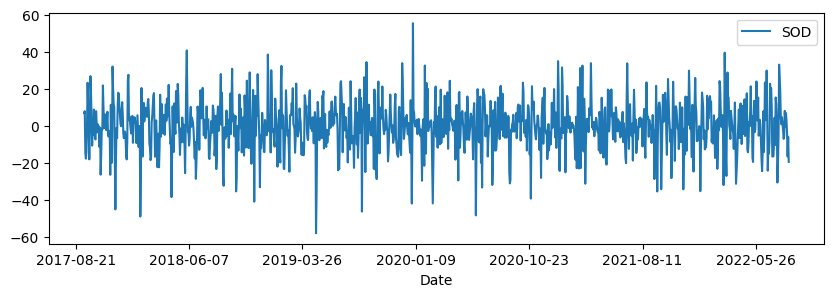

In [1050]:
df.plot(x = "Date",y = "SOD",figsize = (10,3))

Create a New Dataframe with all relevant features:

In [1120]:
features = ["Price Change","Close","Shares Outstanding",'Volume','MACD_hist','STD',"RSI","SOD"]

df_new = df[features]

Create scatter matrix of new features

c:\Users\Angel\anaconda3\envs\tf210\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


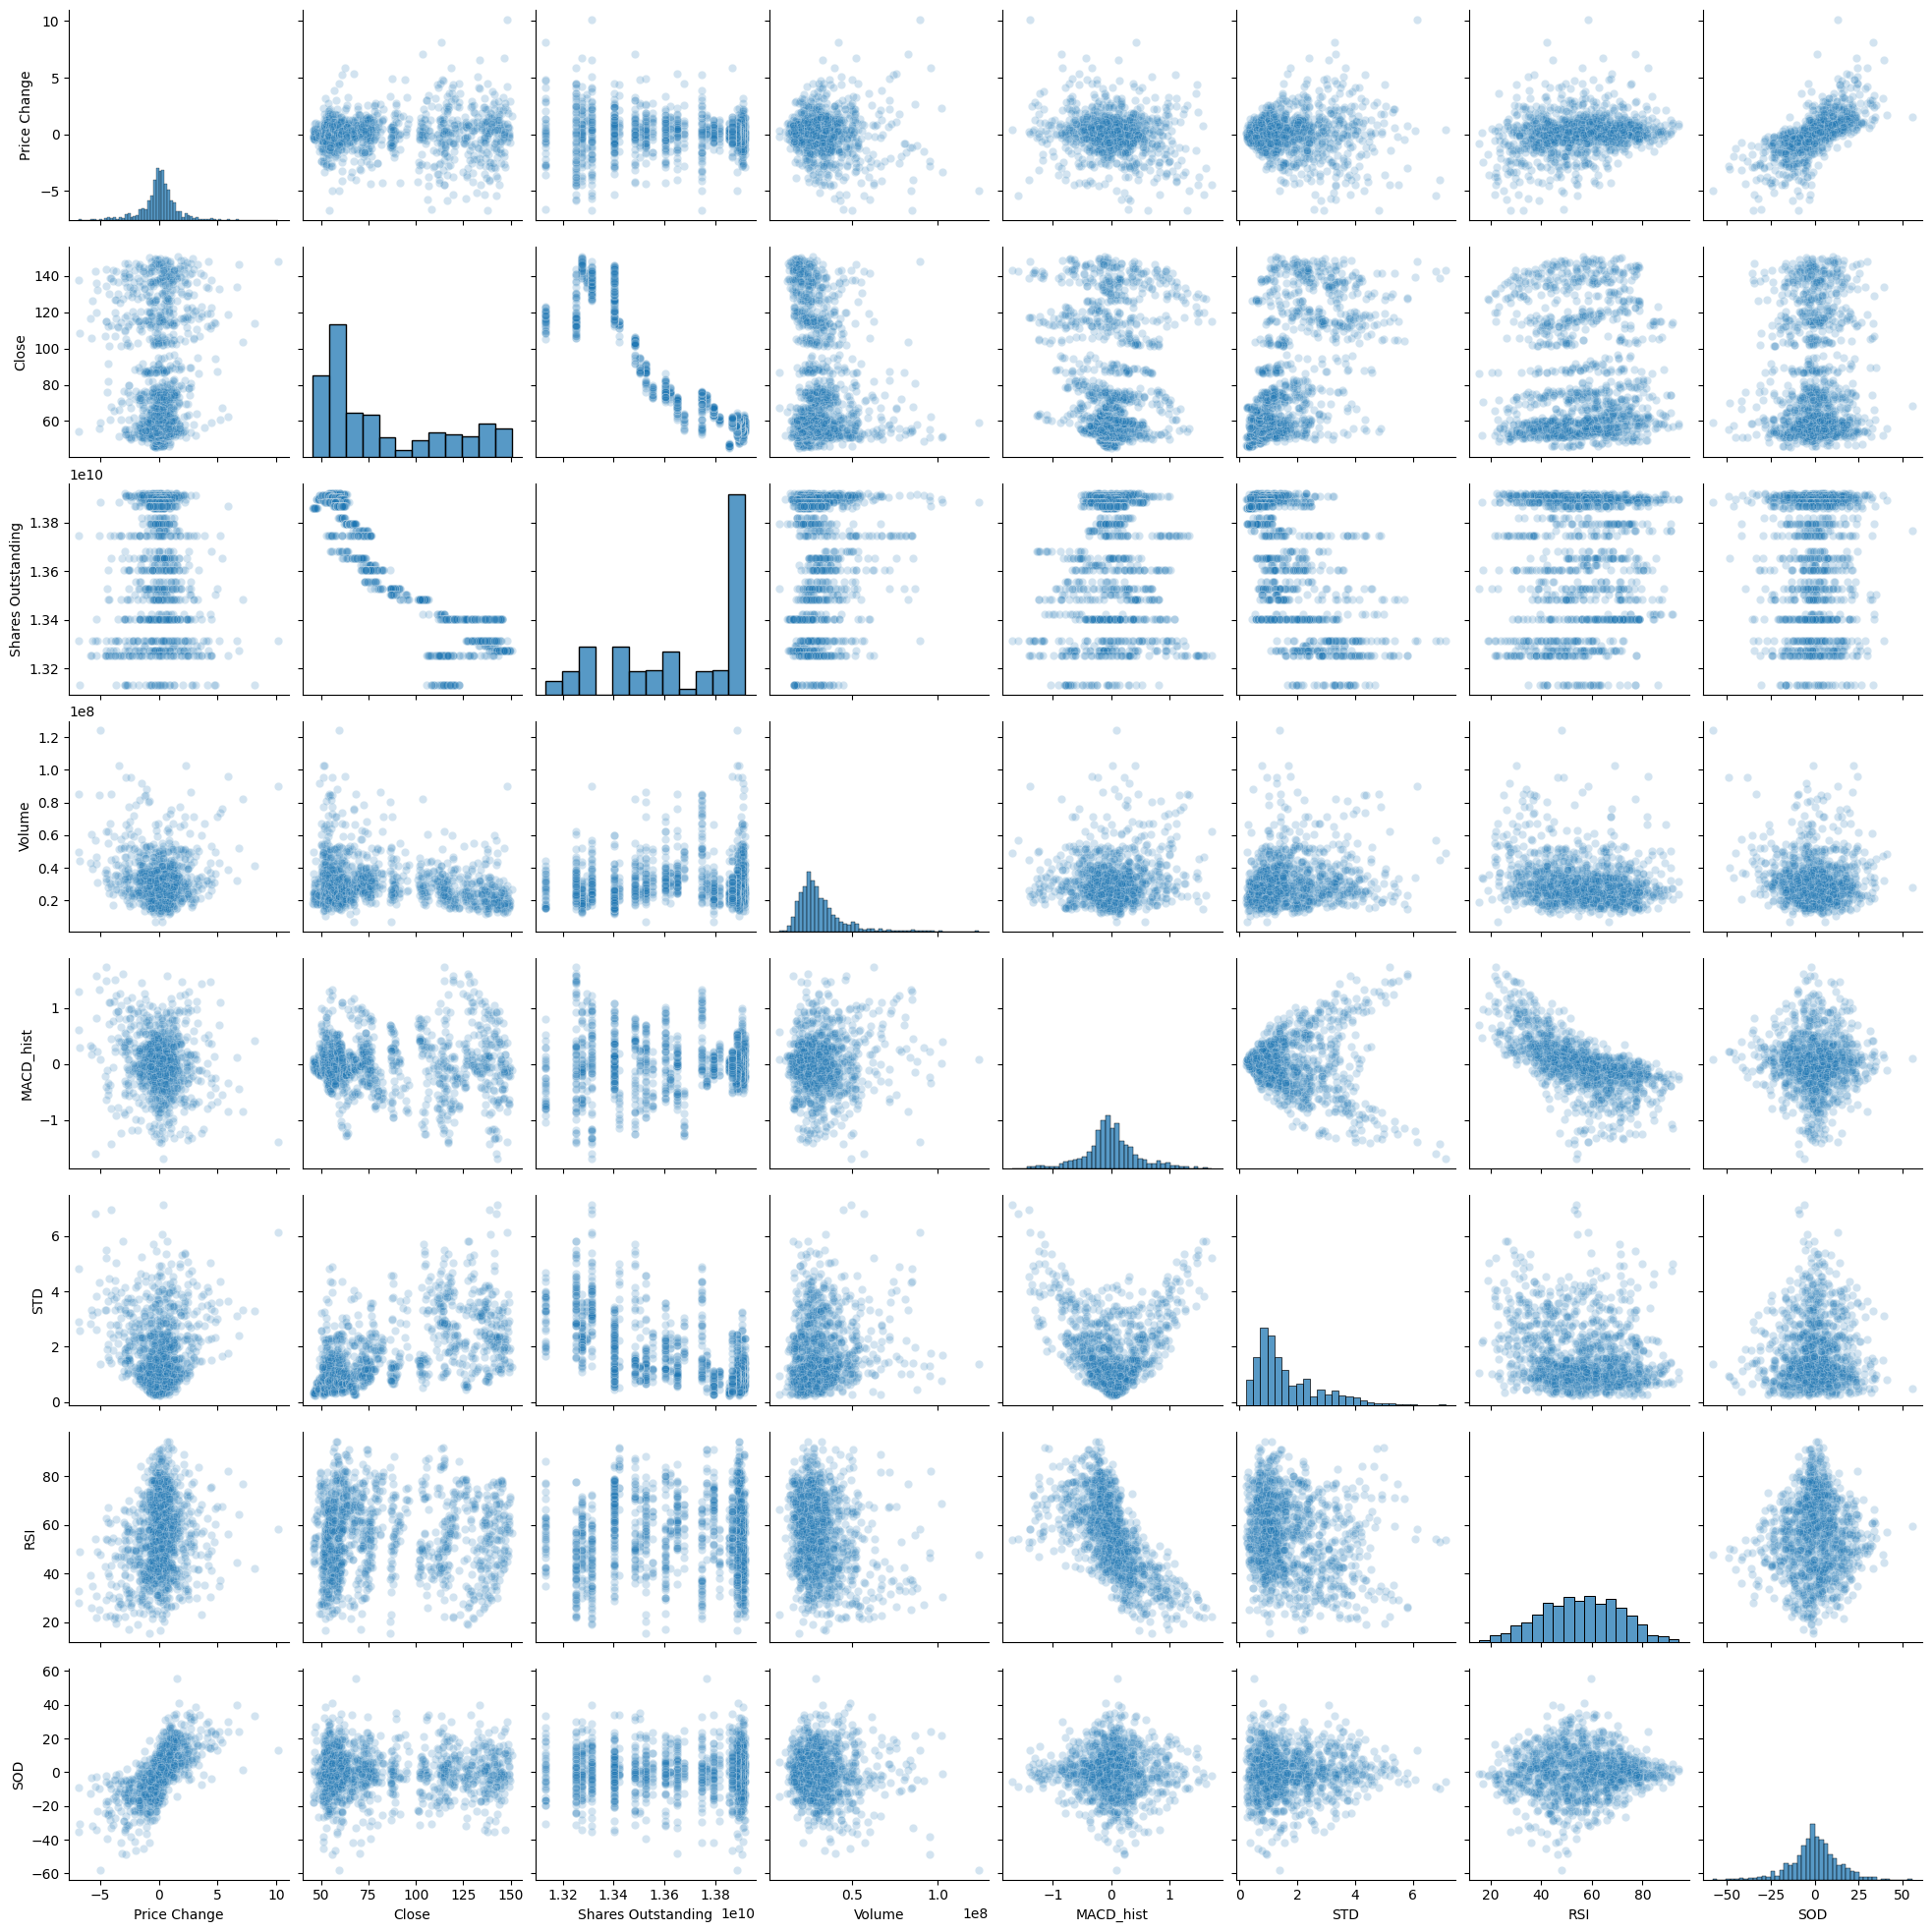

In [1121]:
sns.pairplot(df_new,plot_kws={'alpha': 0.2})
plt.show()

Within this scatter matrix we see many weak correlations between features, as well as some genuine non-linear relationships between features (such as MACD_hist and Standard Deviation). Interestingly enough, much of the non-linear features that I have chosen for this project form nice gaussians, one of which has a clear skew (Standard Deviation). To top it off, let's see the correlation matrix for these features

In [1122]:
correlation_matrix = df_new.corr()

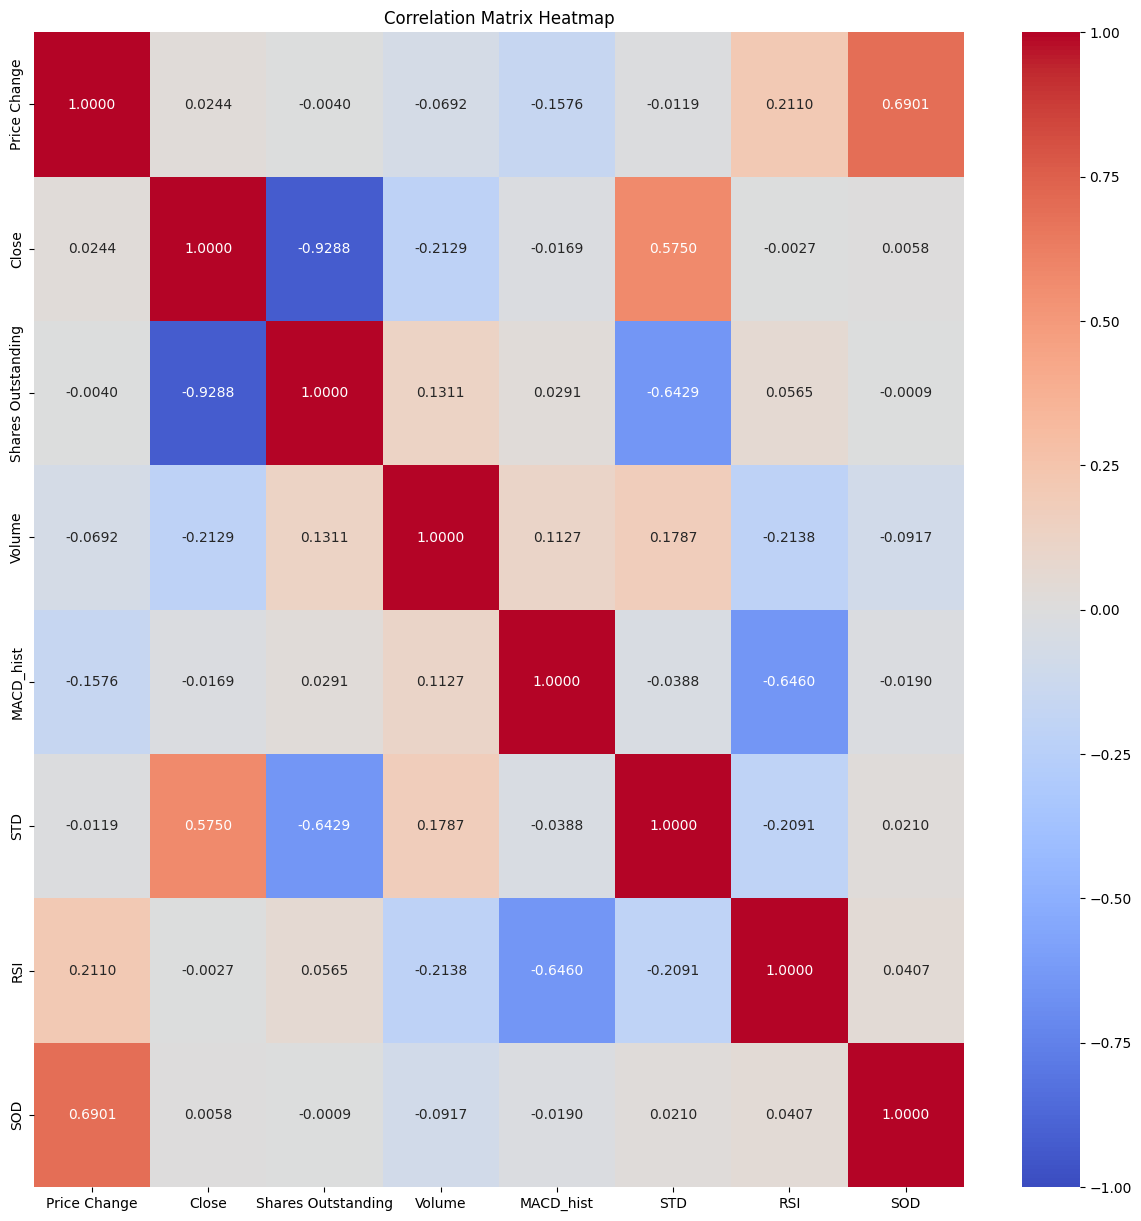

In [1123]:
correlation_matrix = df_new.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".4f")
plt.title("Correlation Matrix Heatmap")
plt.show()

Here we see generally weak correlations (except for shares outstanding). This is generally what I was aiming for, capturing non-linear features within the generally collinear dataset. With this now done, we can now move on to the training schema used for the models.

## Preparing The Data

Before splitting, the first thirty points of the entire dataset must be removed. This "warmup period" has no entries for many of the derived features that required specific periods of the dataset to calculate. As such, the warmup period must be removed

In [1124]:
df_new = df_new.iloc[30:]

Since this is a time-series model, the context of the data is incredibly important. That being said, we must be very care it's safe to day that we must be careful when it comes to our training, so that we don't contaminate and misrepresent the accuracy of our model by allowing the "future" to leak into the "past". To ensure the integrity of the data, the training data is composed of the first 90% of the data, while the validation data is the final 10%.

In [1125]:
train_split = 0.90
train_unscaled = df_new.iloc[:int(len(df_new)*train_split)]
validation_unscaled = df_new.iloc[int(len(df_new)*train_split):]
print(len(train_unscaled) + len(validation_unscaled))

1229


Before it can be fed into the model, the data must be standardized, which means rescaling each feature (separately) such that it's distribution has a mean of 0, and a standard deviation of 1. Standardization was chosen over normalization due to the extreme range in many of the features.

Sometimes, you would want to scale the trending features (such as Close, and SharesOutstanding) in a rolling fashion, such that the nuances within their data are not lost, but since the data already contains features derived from them, such as Price Change, I will standardize them all the same. Most of the features are stationary anyway, so this will do it some good.

Since my model focuses entirely on a single feature, in order to retrieve said feature from the RNN model's output, a separate standard scaler must be created. It performs the exact operation as the first one on the price change feature, but it's just compatible with the model outputs dimensionality.

In [1126]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_unscaled)
validation_scaled = scaler.transform(validation_unscaled)

print(np.std(train_scaled))
print(np.mean(train_scaled))

change_scaler = StandardScaler()
change_scaler.fit(train_unscaled['Price Change'].values.reshape(-1, 1))

1.0
4.3003575384214927e-16


StandardScaler()

#### _The Sliding Window_

Since I want to figure out the number of days my model should precede my prediction day, a "sliding window" approach must be taken. In this, a fixed, n-sized window is defined, and the model works on those n points. Then when done with that window, the window slides forward, to the n-sized window one index over. Doing so allows us to choose how many n days leading up to the forecast horizon we want the model to learn the features of. Much like the blinders on a racehorse, it lets the model focus on what we think is important

In [1127]:
# Sliding window helper function. Created to not clutter main training loop.
# Using yield allows this generator to be iterated over, making windows only when called.
# I did not know about the keras window function when I made this. 
def sliding_window(input_data, train_size, val_size):
    # The upper limit (non-inclusive) for the input data's index
    index_limit = len(input_data) - train_size - val_size + 1
    for i_start in range(0, index_limit):

        #define end of sliding window
        i_end = i_start + train_size + val_size
        
        #create sliding window data
        train_window = input_data[i_start : i_start + train_size]
        val_window = input_data[i_start + train_size : i_end]

        yield train_window, val_window

Now that all of this is out of the way, it's time to finally make the models

## Model Architecture

Since the model will be looking at features ranging from 4-weeks, to 1-week (20 and 5 days preceding forecast respectively), relatively simple RNNs will be used.

The architectures have been chosen with the express purpose of reducing the chance overfitting to the training data, with both having dropout layers following each LSTM layer.

For both models, the optimizer was set to RMSprop, due to its resistance to overfitting when compared to Adam. The loss was chosen to be mean squared error, to more heavily correct the larger mistakes made by the model. The output activation function was also chosen to be linear for the two, since the outputs should still be unbounded despite being stationary features.

Both models have an LSTM with 32 cells preceding their output layer. This was teh compromise chosen for the 8x5,8x10, and 8x20 input features that came with the varying training windows.

The first model, designated as the "simple" one, sports two LSTM layers, with a consistent 32 units between the two of them.

In [ ]:
def make_simple_RNN(train_window, prediction_window, num_features,optimizer = "RMSprop",loss = "mse"):
    model = Sequential([

        LSTM(units = 32,input_shape = (train_window,num_features),return_sequences = True),
        Dropout(0.2),

        LSTM(units = 32),      
        Dropout(0.2),

        Dense(units = prediction_window, activation = "linear")  
    ])
    model.compile(optimizer=optimizer, loss=loss)
    return model

The second model, the "complex" one, has 64 cells to its first LSTM. The purpose of this "funneling"-type architecture is to function almost as a kind of compression, where the second layer is only allowed to retain or recognize the most latent of features extracted by the first layer.

In [1180]:
def make_complex_RNN(train_window, prediction_window, num_features,optimizer = "RMSprop",loss = "mse"):
    model = Sequential([
        
        LSTM(units = 64,input_shape = (train_window,num_features),return_sequences = True),
        Dropout(0.2),

        LSTM(units = 32),      
        Dropout(0.2),

        Dense(units = prediction_window, activation = "linear")  
    ])
    model.compile(optimizer=optimizer, loss=loss)
    return model

## Model Training

In [1147]:
With the models now made, they can be trained.

Before creating the training loop, a function must be made to determine the predictions of a given model. This will be used for select epochs during the training loop, and the results of which will be used during the model evaluation. Although it is not used in my application for this project because it has proven to not work well, the validation function also allows the model to be evaluated "online", as in, training on the most recent data it has already predicted.

The validate model function also has a built-in sanity check, in the form of the "true_values". They are the y-values pulled from the window, that undergo the same inverse transform as the predictions, and if done correctly, the "true_values" array should be the exact same as the "Price Change"

In [1204]:
def validate_model(model,usenewdata = False):
    predictions = []
    true_values = []

    for train_window, val_window in sliding_window(validation_scaled, train_size, val_size):
        #single value batch
        X_train = train_window.reshape(1, train_size, 8)
        #predict and undo standardization
        y_pred = model.predict(X_train)
        y_pred_real = change_scaler.inverse_transform(y_pred)

        #undo standardization
        y_val = val_window[:,0].reshape(1,-1) # reshapes to be usable
        y_val_real = change_scaler.inverse_transform(y_val)

        # pull results from nested lists
        predictions.append(y_pred_real[0][0])
        true_values.append(y_val_real[0][0])
        #online functionality
        if usenewdata == True:
            model.fit(X_train,y_val)

    #append to lists
    predictions = np.array(predictions)
    true_values = np.array(true_values)

    return predictions,true_values

Now the training loop can be made. there's not much to comment on it other than the fact that it calculates the training error, and also returns predictions data at given checkpoints. Although validation MSE could be used instead, I am also interested in how well the model predicts the direction of price changes as well during the evaluation

In [1239]:
def train_RNN(model, epochs, epochlist = np.arange(0,epochs,5)):

    train_mse_epoch = []
    predictions_array = []

    for epoch in range(epochs):
        #temporary MSE list
        train_mse_temp = []
        
        # iterate over windows
        for train_window, val_window in sliding_window(train_scaled, train_size, val_size):
            #single value batch
            X_train = train_window.reshape(1,train_size,8) 
            #pull y-value
            y_train = val_window[:,0].reshape(1,val_size)     
            #train
            MSE = model.train_on_batch(X_train, y_train)

            train_mse_temp.append(MSE)

        #if at a checkpoint, get predicitons and other metrics
        if epoch in epochlist:
            print("epoch is",epoch)

            train_mse_epoch.append(np.mean(train_mse_temp))
            #create predictions for epoch
            predictions_temp,true_values = validate_model(model)

            predictions_array.append([predictions_temp])



    return [train_mse_epoch,true_values,predictions_array]

Set the forecast horizon and # of epochs

In [1240]:
val_size = 1
epochs = 21

Below, I set the respective train sizes for each type of model, and train them. The outputs are intentionally collapsed.

In [1241]:
train_size = 5

simplemodel_t5 = make_simple_RNN(train_size,val_size,8)
complexmodel_t5 = make_complex_RNN(train_size,val_size,8)

simple_t5 = train_RNN(simplemodel_t5, epochs)
complex_t5 = train_RNN(complexmodel_t5, epochs)

epoch is 0
1/1 [==============================] - 0s 14ms/step
epoch is 5
1/1 [==============================] - 0s 13ms/step
epoch is 10
1/1 [==============================] - 0s 15ms/step
epoch is 15
1/1 [==============================] - 0s 14ms/step
epoch is 20
1/1 [==============================] - 0s 14ms/step
epoch is 0
1/1 [==============================] - 0s 15ms/step
epoch is 5
1/1 [==============================] - 0s 15ms/step
epoch is 10
1/1 [==============================] - 0s 15ms/step
epoch is 15
1/1 [==============================] - 0s 14ms/step
epoch is 20
1/1 [==============================] - 0s 20ms/step


In [1242]:
train_size = 10

simplemodel_t10 = make_simple_RNN(train_size,val_size,8)
complexmodel_t10 = make_complex_RNN(train_size,val_size,8)

simple_t10 = train_RNN(simplemodel_t10, epochs)
complex_t10 = train_RNN(complexmodel_t10, epochs)

epoch is 0
1/1 [==============================] - 0s 16ms/step
epoch is 5
1/1 [==============================] - 0s 15ms/step
epoch is 10
1/1 [==============================] - 0s 15ms/step
epoch is 15
1/1 [==============================] - 0s 15ms/step
epoch is 20
1/1 [==============================] - 0s 15ms/step
epoch is 0
1/1 [==============================] - 0s 15ms/step
epoch is 5
1/1 [==============================] - 0s 15ms/step
epoch is 10
1/1 [==============================] - 0s 15ms/step
epoch is 15
1/1 [==============================] - 0s 15ms/step
epoch is 20
1/1 [==============================] - 0s 15ms/step


In [1243]:
train_size = 20

simplemodel_t20 = make_simple_RNN(train_size,val_size,8)
complexmodel_t20 = make_complex_RNN(train_size,val_size,8)

simple_t20 = train_RNN(simplemodel_t20, epochs)
complex_t20 = train_RNN(complexmodel_t20, epochs)

epoch is 0
1/1 [==============================] - 0s 16ms/step
epoch is 5
1/1 [==============================] - 0s 16ms/step
epoch is 10
1/1 [==============================] - 0s 14ms/step
epoch is 15
1/1 [==============================] - 0s 14ms/step
epoch is 20
1/1 [==============================] - 0s 15ms/step
epoch is 0
1/1 [==============================] - 0s 14ms/step
epoch is 5
1/1 [==============================] - 0s 16ms/step
epoch is 10
1/1 [==============================] - 0s 15ms/step
epoch is 15
1/1 [==============================] - 0s 16ms/step
epoch is 20
1/1 [==============================] - 0s 16ms/step


With both models now trained for three separate conditions, it's time to gather the results and evaluate them.

## Results & Model Evaluation 

Below are just some helper functions made to make the plotting go smoother

In [1359]:
# calculates RMSE
def calc_RMSE(true_val,pred_val):
    return np.sqrt(np.mean((true_val - pred_val)**2))
# Calculates directional accuracy. 
# Whether the model predicted up/down correctly or not
def calc_directional_acc(true_val,pred_val):
    truemoves = [val > 0 for val in true_val]
    predmoves = [val > 0 for val in pred_val]
    compared = [p == t for p,t in zip(predmoves,truemoves)]
    return np.sum(compared)/len(compared)

In [1339]:
#loop to allow for plotting accuracy via the nested predictions list
def plot_accuracies(true_values,predictions):
    acc_list = []
    for prediction in predictions:
        prediction = prediction[0]
        acc_list.append(calc_directional_acc(true_values,prediction))
    plt.plot(np.arange(0,epochs,5),acc_list)
# does the same for RMSE
def plot_RMSE(true_values,predictions):
    rms_list = []
    for prediction in predictions:
        prediction = prediction[0]
        rms_list.append(calc_RMSE(true_values,prediction))
    plt.plot(np.arange(0,epochs,5),rms_list)

In [1340]:
#just organized so they can be iterated over
simpledata = [simple_t5,simple_t10,simple_t20]
complexdata = [complex_t5,complex_t10,complex_t20]

Below are the RMSE results for both the "simple" RNN and the "complex" RNN. The Naive baseline for RMSE is the result of the random walk hypothesis, which suggests that the best estimate for tomorrow's price is simply today's price. This would suggest a predicted price change of zero each time, granting us said error.

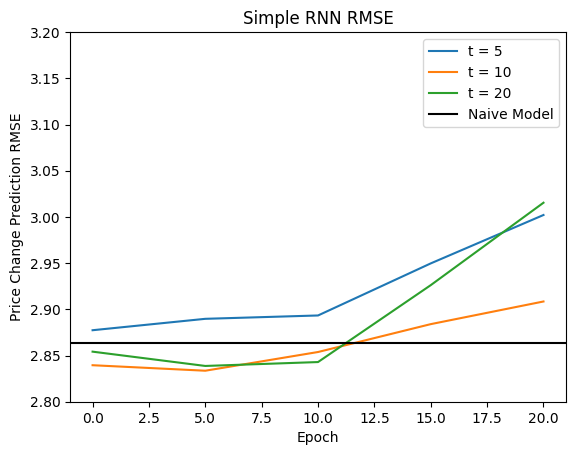

In [1345]:
plt.title("Simple RNN RMSE")
windows = [5,10,20]
for data in simpledata:

    true_values = data[1]
    predictions = data[2]

    plot_RMSE(true_values,predictions)
baseline_RMSE = np.sqrt(np.mean((true_values)**2))

plt.axhline(baseline_RMSE,c = 'black')
leg = ["t = " + str(w) for w in windows]
leg.append("Naive Model")
plt.ylim(2.8,3.2)
plt.xlabel("Epoch")
plt.ylabel("Price Change Prediction RMSE")
plt.legend(leg)

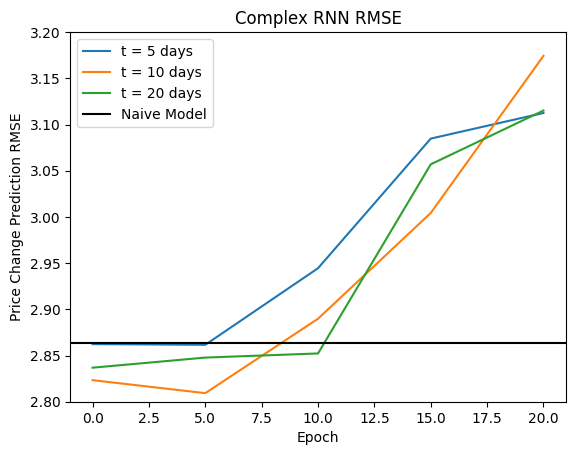

In [1346]:
plt.title("Complex RNN RMSE")
windows = [5,10,20]
for data in complexdata:

    true_values = data[1]
    predictions = data[2]

    plot_RMSE(true_values,predictions)
baseline_RMSE = np.sqrt(np.mean((true_values)**2))

plt.axhline(baseline_RMSE,c = 'black')
leg = ["t = " + str(w) + " days" for w in windows]
leg.append("Naive Model")
plt.ylim(2.8,3.2)
plt.xlabel("Epoch")
plt.ylabel("Price Change Prediction RMSE")
plt.legend(leg)

Within both plots, most if not all model variants seemed capable of beating the baseline Naive model, much to my surprise. While the complex model did diverge into higher RMSE faster than the simple model, it was able to exhibit the lowest RMSE out of the two. Interestingly enough, the minima for both models is seen at epoch 5 for t=10 (two weeks), which suggests that this may be a good fit as far as input feature complexity goes.

Below are plots for the directional accuracy of the same plots for the same hyperparamters.

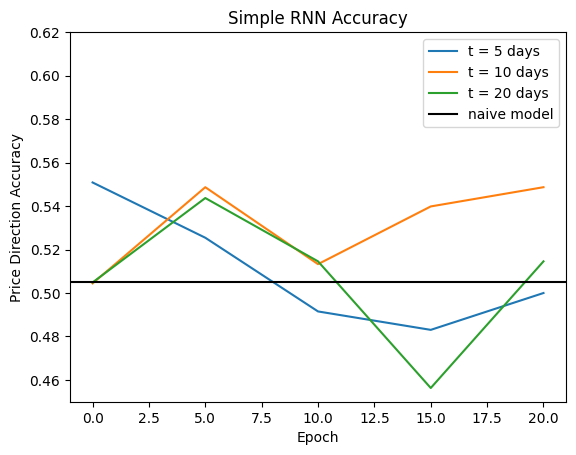

In [1366]:
plt.title("Simple RNN Accuracy")
windows = [5,10,20]
for data in simpledata:

    true_values = data[1]
    predictions = data[2]

    plot_accuracies(true_values,predictions)


plt.axhline(np.mean(true_values < 0),c = 'black')
leg = ["t = " + str(w) + " days" for w in windows]
leg.append("naive model")
plt.ylim(0.45,0.62)
plt.xlabel("Epoch")
plt.ylabel("Price Direction Accuracy")

plt.legend(leg)

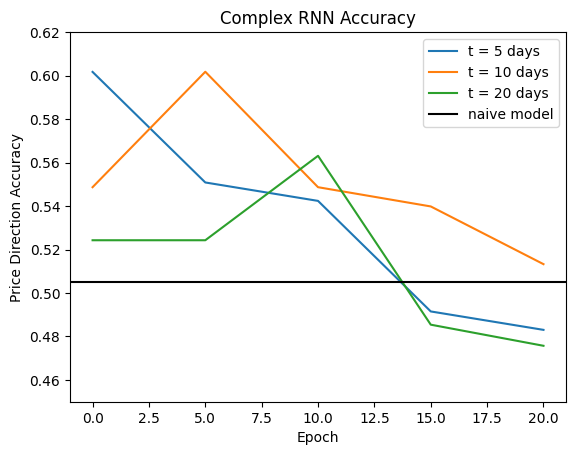

In [1368]:
plt.title("Complex RNN Accuracy")
windows = [5,10,20]
for data in complexdata:

    true_values = data[1]
    predictions = data[2]

    plot_accuracies(true_values,predictions)


plt.axhline(np.mean(true_values < 0),c = 'black')
leg = ["t = " + str(w) + " days" for w in windows]
leg.append("naive model")
plt.ylim(0.45,0.62)
plt.xlabel("Epoch")
plt.ylabel("Price Direction Accuracy")
plt.legend(leg)

I had to check my code a number of times to make sure this was correct, since it was just so high. Above are the directional accuracies for the models, which indicate what fraction of the model's predictions were able to correctly forecast whether tomorrow's close would be higher or lower than today's. This is an undoubtedly great result, made even more so when compared against the naive baseline, which is just the fraction of the most prevalent class in the set. 60% accuracy is by no means a small margin, which lends credence to the thought that the models' lower RMSE was no fluke. Once again in these plots, does the 10-day (2 week) training interval, with both of them acheiving the highest scores of their respective sets. And once again in this model, do we see the Complex model's accuracy handily beat that of the simple model.

To wrap things up, let's go over the actual numbers

In [1371]:
#generate table for RMS
windows = [5,10,20]
results_rms = pd.DataFrame({"epochs":[str(ep) for ep in np.arange(0,21,5)]})
for i,w in enumerate(windows):
    simp,comp = simpledata[i],complexdata[i]

    true_values = simp[1]
    simp_pred_f = simp[2]
    comp_pred_f = comp[2]

    list_s,list_c = [],[]
    for simp_pred,comp_pred in zip(simp_pred_f,comp_pred_f):
        simp_pred,comp_pred = simp_pred[0],comp_pred[0]

        list_s.append(calc_RMSE(true_values,simp_pred))
        list_c.append(calc_RMSE(true_values,comp_pred))

    results_rms["simple t = " + str(w) + " rms"] = list_s
    results_rms["complex t = " + str(w) + " rms"] = list_c

In [1372]:
# Generate table for accuracy
windows = [5,10,20]
results_acc = pd.DataFrame({"epochs":[str(ep) for ep in np.arange(0,21,5)]})
for i,w in enumerate(windows):
    simp,comp = simpledata[i],complexdata[i]

    true_values = simp[1]
    simp_pred_f = simp[2]
    comp_pred_f = comp[2]

    list_s,list_c = [],[]
    for simp_pred,comp_pred in zip(simp_pred_f,comp_pred_f):
        simp_pred,comp_pred = simp_pred[0],comp_pred[0]
        #simp_pred,comp_pred = np.array(simp_pred),np.array(comp_pred)
        list_s.append(calc_directional_acc(true_values,simp_pred))
        list_c.append(calc_directional_acc(true_values,comp_pred))

    results_acc["simple t = " + str(w) + " acc"] = list_s
    results_acc["complex t = " + str(w) + " acc"] = list_c

Below are the displayed tables for both the RMS and accuracy of each model. In both, it can be clearly seen that the complex model using a window of 10 (2 weeks), was able to outperform all others, at 5 epochs, going so far as to acheive 2.81 RMSE, and a 60.2% accuracy.

In [1370]:
results_rms

,epochs,simple t = 5 rms,complex t = 5 rms,simple t = 10 rms,complex t = 10 rms,simple t = 20 rms,complex t = 20 rms
0,0,2.877377,2.862370,2.839507,2.823316,2.854189,2.836838
1,5,2.889722,2.861611,2.833548,2.809280,2.838714,2.847780
2,10,2.893348,2.944492,2.853803,2.889818,2.842929,2.852243
3,15,2.949708,3.084771,2.883972,3.004283,2.926175,3.056932
4,20,3.002082,3.112484,2.908483,3.174315,3.015372,3.115127


In [1373]:
results_acc

,epochs,simple t = 5 acc,complex t = 5 acc,simple t = 10 acc,complex t = 10 acc,simple t = 20 acc,complex t = 20 acc
0,0,0.550847,0.601695,0.504425,0.548673,0.504854,0.524272
1,5,0.525424,0.550847,0.548673,0.601770,0.543689,0.524272
2,10,0.491525,0.542373,0.513274,0.548673,0.514563,0.563107
3,15,0.483051,0.491525,0.539823,0.539823,0.456311,0.485437
4,20,0.500000,0.483051,0.548673,0.513274,0.514563,0.475728


Lastly, here is a confusion matrix of the 5-epoch, 10-day complex model's accuracy

In [1389]:
data_best = complexdata[1][2][1][0] # this data's structure is awful, I know
true_values = complexdata[1][1]
print(calc_directional_acc(true_values,data_best))

data_dir = data_best > 0
true_dir = true_values > 0


0.6017699115044248


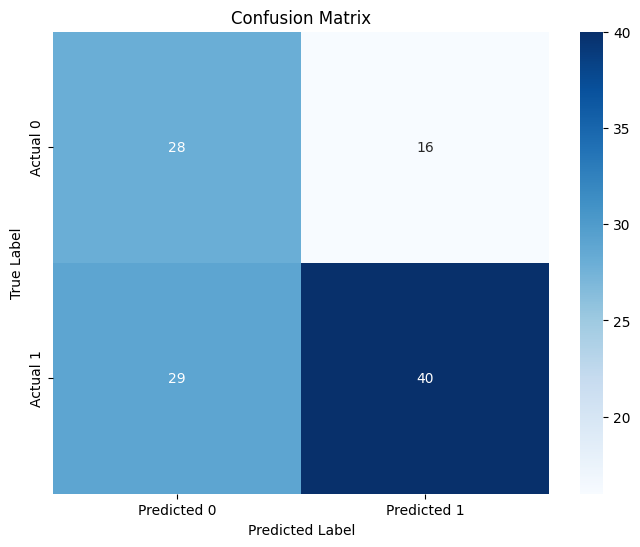

In [1390]:
cm = confusion_matrix(data_dir, true_dir)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix above shows that the best model is fairly proficient at predicting movement in both positive, and negetive directions, which once again, is quite suprising.

## Discussion and Conclusion

Overall, I am very happy with how these results turned out. From the start, I was only expecting to use this project as a means of finding optimal parameters for this particular application, but in addition to that, I got a model that not only was able to beat the both naive models, but it was also able to acheive a 60% directional accuracy for that particular validation window, which I think is remarkable. That being said, the model still has its fair share of issues.

The reason why the model has an RMSE so close to the naive model (which assumes 0 price change interday), is because the value predicted by the model itself became very small. The cause for this is not clear exactly, but it may simply be that the model naturally converged to the naive case, as doing so lowered its' RMSE. Perhaps beyond a certain number of epochs, the model was forced out of it, causing the RMSE to raise to newer heights than before. I'm not sure however, if that could account for the loss in directional accuracy, which would be an artifact of overfitting and poor generalization. That all being said, I'm still quite pleased with how it turned out.

As for improving the project, there are a few things I can think of. I think that implementing some sort of backtesting algorithm would be an important addition to this, which would help prove that this particularly good result was not just the culmination of luck and circumstance. It would also be important to see how a convolutional recurrent neural network architecture, such as wavenet, could handle this problem. Considering that the architectures used in this were relatively simple compared to others out there, it could be the next step to take these predictions to the next level.


